In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import VBMicrolensing as vbm
import scipy.optimize as op
import emcee

Load the data

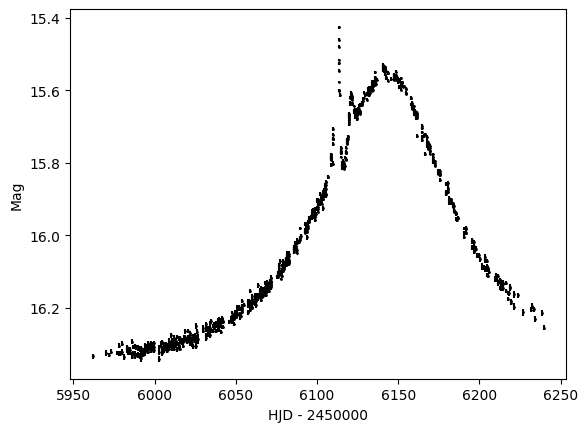

In [2]:

#Load data (row 1 is header)
df = pd.read_csv('2012-BLG-0406_data.txt', sep='\t', header=0)
#load parameters into a dictionary
params = np.loadtxt('2012-BLG-0406_params.txt', unpack=True, skiprows=1, dtype=str)
params_dict = dict(zip(params[0], np.float64(params[1])))
#select only data points where t is in range t0 - 5*tE and t0 + 5*tE
t0i = params_dict['Tmax'] - 2450000
tEi = params_dict['tau']
u0i = params_dict['umin']

df = df[(df['HJD-2450000'] > t0i - 4*tEi) & (df['HJD-2450000'] < t0i + 4*tEi)]

#Plot data
plt.errorbar(df['HJD-2450000'], df['I_Mag'], yerr=df['Err'], fmt='o', color='black', label='data', markersize=1)
plt.xlabel('HJD - 2450000')
plt.ylabel('Mag')
#Invert the y-axis
plt.gca().invert_yaxis()
plt.show()

Convert from magnitudes to fluxes

In [3]:
#Convert from magnitudes to fluxes
def mag2flux(mag: np.ndarray, 
             zp: float = 25.0
             ) -> np.ndarray:
    '''
    Converts magnitude values (array) to flux.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    f : np.ndarray
        Array of fluxes.
    '''
    f = 10.0**((mag - zp) / -2.5)
    return f

def mag2flux_err(mag: np.ndarray, mag_err: np.ndarray, 
                 zp: float = 25.0):
    '''
    Converts magnitude values and errors (array) to flux using error propagation formula.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    mag_err : np.ndarray
        Array of magnitude errors.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    flux_err : np.ndarray
        Array of flux errors.
    '''
    dfdmag = -0.4 * np.log(10) * 10.**(0.4*(zp-mag))
    flux_err = np.sqrt(dfdmag**2 * mag_err**2)
    return flux_err

df['I_band_flux'] = mag2flux(df['I_Mag'], 25.0)
df['I_band_flux_err'] = mag2flux_err(df['I_Mag'], df['Err'], 25.0)

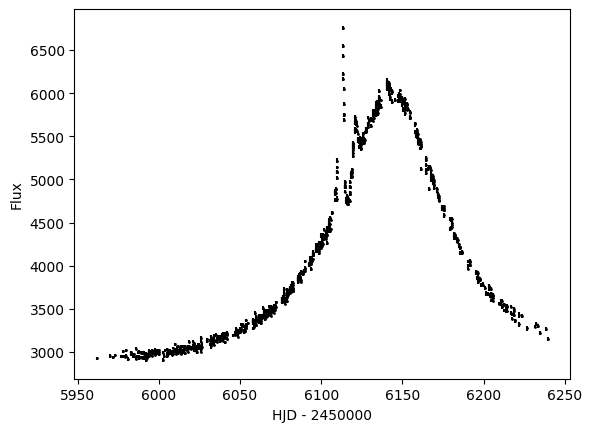

In [34]:
#Plot data
#Plot data
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')

plt.show()

In [24]:
def calc_Fs(modelmag: np.ndarray, f: np.ndarray, sig2: np.ndarray) -> tuple[float, float]:
    '''
    Solves for the flux parameters for a given model using least squares.
    
    Parameters
    ----------
    model : np.ndarray
        Model magnification curve.
    f : np.ndarray
        Observed flux values.
    sig2 : np.ndarray
        Flux errors.
    
    Returns
    -------
    FS : float
        Source flux.
    FB : float
        Blend flux.
    '''
    #A
    A11 = np.sum(modelmag**2 / sig2)
    Adiag = np.sum(modelmag / sig2) 
    A22 = np.sum(1.0 / sig2)
    A = np.array([[A11,Adiag], [Adiag, A22]])
     
    #C
    C1 = np.sum((f * modelmag) / sig2)
    C2 = np.sum(f / sig2)
    C = np.array([C1, C2]).T
     
    #B
    B = np.linalg.solve(A,C)
    FS = float(B[0])
    FB = float(B[1])
    
    return FS, FB

def get_mag(x0, p, t):
    '''
    Get the magnification curve for a given model and parameters.
    
    Parameters
    ----------
    x0: np.ndarray with initial parameters (t0, tE, u0, rho)
    p: list[str] with parameter names
    t: np.ndarray with data epochs
    
    Returns
    -------
    mag: np.ndarray with magnification curve
    '''
     #create a dictionary of parameters
    VBM = vbm.VBMicrolensing()
    params = dict(zip(p, x0))
    paramsc = params.copy()
    tau = (t - paramsc['t0']) / paramsc['tE'] 
    if len(p) < 7 :
        #single lens
        ul = np.sqrt(tau**2 + paramsc['u0']**2)
        if 'logrho' in paramsc.keys():
            paramsc['rho'] = 10**(paramsc['logrho'])
        mag = np.array([VBM.ESPLMag2(u, paramsc['rho']) for u in ul])
    elif len(p) >= 7:
        salpha = np.sin(np.radians(paramsc['alpha']))
        calpha = np.cos(np.radians(paramsc['alpha']))
        y1s = -paramsc['u0'] * salpha + tau * calpha  # source positions - Mulens model alpha convention. Angle between vector joining com to planet and trajectory (measured from binary axis)
        y2s = paramsc['u0'] * calpha + tau * salpha
        y1s = y1s.values
        y2s = y2s.values
        if 'logs' in paramsc.keys():
            paramsc['s'] = 10**(paramsc['logs'])
        if 'logq' in paramsc.keys():
            paramsc['q'] = 10**(paramsc['logq'])
        if 'logrho' in paramsc.keys():
            paramsc['rho'] = 10**(paramsc['logrho'])
        mag = np.array([VBM.BinaryMag2(paramsc['s'], paramsc['q'], y1s[i], y2s[i], paramsc['rho']) for i in range(len(y1s))])
    return mag

def chi2(x0: np.ndarray, p: list, t: np.ndarray, f: np.ndarray, sig: np.ndarray) -> float:
    '''
    Calculates the chi squared value for a given model and parameters.
    
    Parameters
    ----------
    x0 : np.ndarray
        Initial parameters.
    p : List[str]
        List of parameter names.
    t : np.ndarray
        Data epochs.
    f : np.ndarray
        Observed flux values.
    sig : np.ndarray
        Flux errors.
    
    Returns
    -------
    chi2 : float
        Chi squared value.
    '''
    mag = get_mag(x0, p, t)
    FS, FB = calc_Fs(mag, f, sig**2)
    model = FS * mag + FB
    
    chi2_value = np.sum((f - model)**2 / sig**2)

    return chi2_value

def simple_fit(df: pd.DataFrame, x0: np.ndarray, p: list[str]):
    '''
    Fit a single or binary lens model using downhill simplex method and find $\delta \chi^2$
    df: dataframe with data epochs, flux, and flux errors
    x0: np.ndarray with initial parameters (t0, tE, u0, rho)
    p: list[str] with parameter names

    Returns
    -------
    fin_params: dictionary with final parameters (t0, tE, u0, rho)
    fin_chi2: float
       Final Chi squared value
    delta_chi2: float
        Delta chi squared between best fit model and perfect model
    '''
    t = df['HJD-2450000']
    f = df['I_band_flux']
    sig = df['I_band_flux_err']

    #Set reasonable bounds for parameters 
    bounds_list = {'t0': (t.min(), t.max()), 'tE': (0.1, 100), 'u0': (-10.0, 10.0), 'rho': (1e-5, 1.0), 's': (1e-2, 20.0), 'q': (1e-7, 1.0), 'alpha': (0.0, 360.0), 'logs': (-2, 2), 'logq': (-7, 0), 'logrho': (-5, 0)}
    bounds = [bounds_list[p[i]] for i in range(len(p))]

    result = op.minimize(
       chi2, x0, args=(p, t, f, sig), bounds=bounds,
       method='Nelder-Mead', options={'xatol': 1e-8, 'fatol': 1e-8, 'adaptive': False, 'maxfev' : 1000})
    
    if isinstance(result.fun, np.ndarray):
            if result.fun.ndim == 0:
                fin_chi2 = float(result.fun)
            else:
                fin_chi2 = result.fun[0]
    else:
            fin_chi2 = result.fun
    
    fin_params = dict(zip(p, result.x))
    delta_chi2 = fin_chi2 - (len(f) - len(p))

    
    return fin_params, fin_chi2, delta_chi2


def log_prior(x0, p, t):
    ''' bounds on parameter
    
    Parameters
    ----------
    x0: np.ndarray with initial parameters (t0, tE, u0, rho)
    p: list[str] with parameter names
    t: np.ndarray with data epochs
    '''

    bounds_list = {'t0': (t.min(), t.max()), 'tE': (0.1, t.max()-t.min()), 'u0': (-10.0, 10.0), 'rho': (1e-5, 1.0), 's': (1e-2, 20.0), 'q': (1e-7, 1.0), 'alpha': (0.0, 360.0), 'logs': (-2, 2), 'logq': (-7, 0), 'logrho': (-5, 0)}
    in_bound = True
    for index, key in enumerate(p):
        if x0[index] < bounds_list[key][0] or x0[index] > bounds_list[key][1]:
            in_bound = False
            break
    if in_bound:
        return 0.
    else:
        return -np.inf      

def log_likelihood(x0, p, t, f, sig):
    '''calculating chi2'''
    ll = -1./2. * chi2(x0, p, t, f, sig)
    return ll

def log_probability(x0, p, t, f, sig):
    lp = 0.
    lp += log_prior(x0, p, t)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(x0, p, t, f, sig)

def run_mcmc(df, x0, p, steps=500, walkers=100, step_scale=1e-4, 
             param_scales=None, verbose=False):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with data epochs, flux, and flux errors
    x0 : np.ndarray
        Initial parameters (t0, tE, u0, rho, etc.)
    p : list[str]
        Parameter names
    steps : int, optional
        Number of MCMC steps (default: 500)
    walkers : int, optional
        Number of walkers (default: 100)
    step_scale : float, optional
        Global step size scaling factor (default: 1e-4)
    param_scales : np.ndarray, optional
        Individual scaling for each parameter (default: None)
    verbose : bool, optional
        Print step size information (default: False)
    
    Returns
    -------
    sampler, pos, prob, state
        MCMC sampler results
    """
    # Take the initial starting point from the event.
    t = df['HJD-2450000']
    f = df['I_band_flux']
    sig = df['I_band_flux_err']

    # Create initial starting points for all walkers.
    nwalkers, ndim = walkers, len(x0)
    
    if param_scales is not None:
        # Use parameter-specific scaling
        if len(param_scales) != ndim:
            raise ValueError(f"param_scales length ({len(param_scales)}) must match parameters ({ndim})")
        scales = param_scales
        if verbose:
            print("Using parameter-specific step sizes:")
            for i, param in enumerate(p):
                print(f"  {param}: {scales[i]:.2e}")
    else:
        # Use global scaling
        scales = step_scale
        if verbose:
            print(f"Using global step size: {step_scale:.2e}")
    
    p0state = x0 + scales * np.random.randn(nwalkers, ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(p, t, f, sig))
    
    # Run MCMC
    pos, prob, state = sampler.run_mcmc(p0state, steps, progress=True)

    return sampler, pos, prob, state

def gelman_rubin_statistic(chains):
    """Calculate Gelman-Rubin R-hat statistic for convergence assessment"""
    n_walkers, n_steps, n_params = chains.shape
    
    if n_steps < 4:
        return np.full(n_params, np.nan)
    
    # Split each chain in half
    half_steps = n_steps // 2
    chains_split = chains[:, -2*half_steps:, :].reshape(2*n_walkers, half_steps, n_params)
    
    r_hat = np.zeros(n_params)
    
    for i in range(n_params):
        chain_means = np.mean(chains_split[:, :, i], axis=1)
        chain_vars = np.var(chains_split[:, :, i], axis=1, ddof=1)
        
        overall_mean = np.mean(chain_means)
        between_var = half_steps * np.var(chain_means, ddof=1)
        within_var = np.mean(chain_vars)
        
        var_estimate = ((half_steps - 1) * within_var + between_var) / half_steps
        r_hat[i] = np.sqrt(var_estimate / within_var) if within_var > 0 else 1.0
    
    return r_hat

def effective_sample_size(chains):
    """Estimate effective sample size"""
    n_walkers, n_steps, n_params = chains.shape
    eff_sizes = np.zeros(n_params)
    
    for i in range(n_params):
        # Flatten chains for this parameter
        flat_chain = chains[:, :, i].flatten()
        
        # Simple autocorrelation-based estimate
        autocorr = np.correlate(flat_chain - np.mean(flat_chain), 
                               flat_chain - np.mean(flat_chain), mode='full')
        autocorr = autocorr[autocorr.size // 2:]
        autocorr = autocorr / autocorr[0]
        
        # Find where autocorr drops below 1/e
        try:
            cutoff = np.where(autocorr < 1/np.e)[0][0]
            eff_sizes[i] = len(flat_chain) / (2 * cutoff + 1)
        except IndexError:
            eff_sizes[i] = len(flat_chain) / 10  # Conservative estimate
    
    return eff_sizes

def plot_corner_mcmc(samples, param_names, title="MCMC Posterior Distributions"):
    """Plot corner plot of MCMC samples"""
    try:
        import corner
    except ImportError:
        import subprocess
        import sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'corner'])
        import corner
    
    fig = corner.corner(samples, labels=param_names, 
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},
                       label_kwargs={"fontsize": 14})
    
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    return fig

def plot_mcmc_fit(df, mle_params, param_names, mle_delta_chi2):
    """Plot the best fit model from MCMC"""
    mle_modelmag = get_mag(mle_params, param_names, df['HJD-2450000'])
    source_flux, blend_flux = calc_Fs(mle_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
    mle_model = source_flux * mle_modelmag + blend_flux
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], 
                 fmt='o', color='black', label='Data', markersize=2, alpha=0.7)
    plt.plot(df['HJD-2450000'], mle_model, color='red', linewidth=2, 
             label=f'MCMC Best Fit - $\\Delta \\chi^2 = {mle_delta_chi2:.2f}$')
    plt.xlabel('HJD - 2450000', fontsize=12)
    plt.ylabel('Flux', fontsize=12)
    plt.title('Binary Lens Model - MCMC Fit', fontsize=14)
    plt.legend(loc='upper left', framealpha=0.8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return fig

def plot_mcmc_traces(sampler, param_names, burn_in):
    """Plot MCMC trace plots for convergence diagnosis"""
    fig, axes = plt.subplots(len(param_names), 1, figsize=(12, 2*len(param_names)), sharex=True)
    if len(param_names) == 1:
        axes = [axes]
    
    for i in range(len(param_names)):
        # Plot all walker chains
        for j in range(sampler.chain.shape[0]):
            axes[i].plot(sampler.chain[j, :, i], color='k', alpha=0.1, linewidth=0.5)
        
        # Highlight a few random walkers for clarity
        random_walkers = np.random.choice(sampler.chain.shape[0], size=min(5, sampler.chain.shape[0]), replace=False)
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for idx, walker in enumerate(random_walkers):
            color = colors[idx % len(colors)]
            axes[i].plot(sampler.chain[walker, :, i], color=color, alpha=0.7, linewidth=1.2, 
                        label=f'Walker {walker}' if i == 0 else '')
        
        axes[i].axvline(burn_in, color='red', linestyle='--', linewidth=2, label='Burn-in' if i == 0 else '')
        axes[i].set_ylabel(f'{param_names[i]}', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    axes[-1].set_xlabel('Step Number', fontsize=12)
    plt.suptitle('MCMC Trace Plots - Individual Walker Chains', fontsize=16)
    plt.tight_layout()
    plt.show()
    return fig

def plot_convergence_diagnostics(sampler, param_names, burn_in):
    """Plot running statistics to check convergence"""
    fig, axes = plt.subplots(len(param_names), 2, figsize=(16, 2*len(param_names)))
    if len(param_names) == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(len(param_names)):
        # Calculate running mean and std
        chain_flat = sampler.chain[:, :, i]
        running_mean = np.zeros((chain_flat.shape[0], chain_flat.shape[1]))
        running_std = np.zeros((chain_flat.shape[0], chain_flat.shape[1]))
        
        for walker in range(chain_flat.shape[0]):
            for step in range(1, chain_flat.shape[1]):
                running_mean[walker, step] = np.mean(chain_flat[walker, :step+1])
                running_std[walker, step] = np.std(chain_flat[walker, :step+1])
        
        # Plot running mean
        step_numbers = np.arange(chain_flat.shape[1])
        for walker in range(min(10, chain_flat.shape[0])):
            axes[i, 0].plot(step_numbers, running_mean[walker, :], alpha=0.6, linewidth=1)
        
        axes[i, 0].axvline(burn_in, color='red', linestyle='--', linewidth=2, label='Burn-in')
        axes[i, 0].set_ylabel(f'Running Mean - {param_names[i]}', fontsize=12)
        axes[i, 0].set_title(f'{param_names[i]} - Running Mean Convergence', fontsize=12)
        axes[i, 0].grid(True, alpha=0.3)
        if i == 0:
            axes[i, 0].legend()
        
        # Plot running standard deviation
        for walker in range(min(10, chain_flat.shape[0])):
            axes[i, 1].plot(step_numbers, running_std[walker, :], alpha=0.6, linewidth=1)
        
        axes[i, 1].axvline(burn_in, color='red', linestyle='--', linewidth=2, label='Burn-in')
        axes[i, 1].set_ylabel(f'Running Std - {param_names[i]}', fontsize=12)
        axes[i, 1].set_title(f'{param_names[i]} - Running Std Convergence', fontsize=12)
        axes[i, 1].grid(True, alpha=0.3)
        if i == 0:
            axes[i, 1].legend()
    
    axes[-1, 0].set_xlabel('Step Number', fontsize=12)
    axes[-1, 1].set_xlabel('Step Number', fontsize=12)
    plt.suptitle('MCMC Convergence Diagnostics - Running Statistics', fontsize=16)
    plt.tight_layout()
    plt.show()
    return fig

def perform_mcmc_analysis(df, x0, param_names, steps=3000, walkers=50, 
                         step_scale=1e-4, param_scales=None,
                         verbose=False, plot_corner=False, plot_fit=False, 
                         plot_traces=False, plot_convergence=False):
    """
    Perform complete MCMC analysis of binary lens model
    
    Parameters
    ----------
    df : pandas.DataFrame
        Data with columns 'HJD-2450000', 'I_band_flux', 'I_band_flux_err'
    x0 : np.ndarray
        Initial parameter values
    param_names : list
        List of parameter names
         steps : int, optional
         Number of MCMC steps (default: 3000)
     walkers : int, optional
         Number of walkers (default: 50)
     step_scale : float, optional
         Global step size scaling factor (default: 1e-4)
     param_scales : np.ndarray, optional
         Individual scaling for each parameter (default: None)
     verbose : bool, optional
        If True, print detailed diagnostics (default: False)
    plot_corner : bool, optional
        If True, show corner plot (default: False)
    plot_fit : bool, optional
        If True, show best fit model plot (default: False)
    plot_traces : bool, optional
        If True, show trace plots (default: False)
    plot_convergence : bool, optional
        If True, show convergence diagnostics (default: False)
    
    Returns
    -------
    results : dict
        Dictionary containing sampler, samples, MLE parameters, statistics, etc.
    """
    
    if verbose:
        print("Running MCMC with binary lens model...")
        print("Initial parameters:", dict(zip(param_names, x0)))
    
                   # Run MCMC
    sampler, pos, prob, state = run_mcmc(df, x0, param_names, steps=steps, walkers=walkers,
                                         step_scale=step_scale, param_scales=param_scales, 
                                         verbose=verbose)
     
     # Calculate acceptance fraction
    mean_acceptance = np.mean(sampler.acceptance_fraction)
    if verbose:
        print(f"\\nMean acceptance fraction: {mean_acceptance:.3f}")
    
    # Calculate autocorrelation time with error handling
    try:
        autocorr_times = sampler.get_autocorr_time()
        if verbose:
            print(f"Autocorrelation times: {autocorr_times}")
            print(f"Max autocorrelation time: {np.max(autocorr_times):.1f}")
            
            chain_length = sampler.chain.shape[1]
            steps_needed = int(50 * np.max(autocorr_times))
            if chain_length < steps_needed:
                print(f"WARNING: Chain may not be converged. Consider running {steps_needed} steps.")
            else:
                print("Chain length appears adequate for convergence.")
                
    except Exception as e:
        if verbose:
            print(f"Cannot reliably calculate autocorrelation time: {e}")
            print("Using alternative convergence diagnostics...")
        autocorr_times = None
    
    # Determine burn-in period
    if autocorr_times is not None:
        burn_in = min(int(2 * np.max(autocorr_times)), int(0.5 * sampler.chain.shape[1]))
    else:
        burn_in = int(0.3 * sampler.chain.shape[1])
    
    if verbose:
        print(f"Using burn-in period: {burn_in} steps ({burn_in/sampler.chain.shape[1]*100:.1f}% of chain)")
    
    samples = sampler.chain[:, burn_in:, :].reshape((-1, len(param_names)))
    
    # Calculate convergence diagnostics
    post_burnin_chains = sampler.chain[:, burn_in:, :]
    r_hat_values = gelman_rubin_statistic(post_burnin_chains)
    eff_sizes = effective_sample_size(post_burnin_chains)
    
    if verbose:
        print(f"\\nGelman-Rubin R-hat statistics (should be < 1.1 for convergence):")
        for i, param in enumerate(param_names):
            if not np.isnan(r_hat_values[i]):
                status = "✓ Good" if r_hat_values[i] < 1.1 else "⚠ Poor" if r_hat_values[i] < 1.2 else "✗ Bad"
                print(f"{param}: {r_hat_values[i]:.4f} ({status})")
            else:
                print(f"{param}: Unable to calculate")
        
        print(f"\\nEffective sample sizes:")
        for i, param in enumerate(param_names):
            print(f"{param}: {eff_sizes[i]:.0f} (out of {len(samples)} total samples)")
    
    # Find MLE
    max_likelihood_idx = np.argmax(sampler.lnprobability[:, burn_in:].flatten())
    mle_params = samples[max_likelihood_idx]
    mle_dict = dict(zip(param_names, mle_params))
    
    # Calculate percentiles
    percentiles = np.percentile(samples, [16, 50, 84], axis=0)
    medians = percentiles[1]
    upper_errors = percentiles[2] - percentiles[1]
    lower_errors = percentiles[1] - percentiles[0]
    
    # Calculate chi-squared for MLE
    mle_chi2 = chi2(mle_params, param_names, df['HJD-2450000'], df['I_band_flux'], df['I_band_flux_err'])
    mle_delta_chi2 = mle_chi2 - (len(df) - len(param_names))
    
    # Print basic results (always shown)
    print("\\nMaximum Likelihood Estimate (MLE) parameters:")
    for param, value in mle_dict.items():
        print(f"{param}: {value:.6f}")
    
    print("\\nMedian values with 1σ uncertainties:")
    for i, param in enumerate(param_names):
        print(f"{param}: {medians[i]:.6f} +{upper_errors[i]:.6f} -{lower_errors[i]:.6f}")
    
    print(f"\\nMLE Chi-squared: {mle_chi2:.2f}")
    print(f"MLE Reduced chi-squared: {mle_chi2/(len(df)-len(param_names)):.2f}")
    print(f"MLE Delta chi-squared: {mle_delta_chi2:.2f}")
    
    # Assessment and recommendations
    convergence_issues = []
    recommendations = []
    
    if mean_acceptance < 0.2:
        convergence_issues.append("Low acceptance fraction")
        recommendations.append("- Consider decreasing step size in proposal distribution")
    elif mean_acceptance > 0.7:
        convergence_issues.append("High acceptance fraction")
        recommendations.append("- Consider increasing step size in proposal distribution")
    
    if not np.isnan(r_hat_values).all():
        poor_rhat = np.sum((r_hat_values > 1.1) & ~np.isnan(r_hat_values))
        if poor_rhat > 0:
            convergence_issues.append(f"{poor_rhat} parameters have R-hat > 1.1")
            recommendations.append("- Run longer chains for better mixing")
    
    min_eff_size = np.min(eff_sizes)
    if min_eff_size < 100:
        convergence_issues.append("Low effective sample sizes")
        recommendations.append("- Run longer chains to increase effective sample size")
    
    if autocorr_times is not None:
        max_tau = np.max(autocorr_times)
        chain_length = sampler.chain.shape[1]
        if chain_length < 50 * max_tau:
            convergence_issues.append("Chain too short relative to autocorrelation time")
            recommendations.append(f"- Run at least {int(50 * max_tau)} steps for reliable results")
    
    print("\\n" + "="*60)
    print("CONVERGENCE SUMMARY")
    print("="*60)
    
    if convergence_issues:
        print("⚠ POTENTIAL CONVERGENCE ISSUES:")
        for issue in convergence_issues:
            print(f"  • {issue}")
        
    
        print("\\n💡 RECOMMENDATIONS:")
        for rec in recommendations:
            print(f"  {rec}")
    else:
        print("✅ MCMC appears to have converged well!")
    
    print(f"\\n📊 SUMMARY:")
    print(f"  • Total steps: {sampler.chain.shape[1]}")
    print(f"  • Burn-in: {burn_in} steps")
    print(f"  • Effective samples: {len(samples)}")
    print(f"  • Acceptance rate: {mean_acceptance:.3f}")
    if autocorr_times is not None:
        print(f"  • Max autocorr time: {np.max(autocorr_times):.1f}")
    print(f"  • Min effective size: {min_eff_size:.0f}")
    if not np.isnan(r_hat_values).all():
        print(f"  • Max R-hat: {np.nanmax(r_hat_values):.3f}")
    
    print("\\n" + "="*60)
    
    # Generate plots if requested
    if plot_corner:
        plot_corner_mcmc(samples, param_names)
    
    if plot_fit:
        plot_mcmc_fit(df, mle_params, param_names, mle_delta_chi2)
    
    if plot_traces:
        plot_mcmc_traces(sampler, param_names, burn_in)
    
    if plot_convergence:
        plot_convergence_diagnostics(sampler, param_names, burn_in)
    
    # Return results dictionary
    results = {
        'sampler': sampler,
        'samples': samples,
        'mle_params': mle_params,
        'mle_dict': mle_dict,
        'medians': medians,
        'upper_errors': upper_errors,
        'lower_errors': lower_errors,
        'mle_chi2': mle_chi2,
        'mle_delta_chi2': mle_delta_chi2,
        'burn_in': burn_in,
        'mean_acceptance': mean_acceptance,
        'autocorr_times': autocorr_times,
        'r_hat_values': r_hat_values,
        'eff_sizes': eff_sizes,
        'convergence_issues': convergence_issues,
        'recommendations': recommendations
    }
    
    return results

Fit a single lens model and find $\Delta \chi^2$


Final parameters:  {'t0': 6141.666273273621, 'tE': 54.27628835952651, 'u0': 0.6899691274368214, 'rho': 0.0008492237065522408}
Reduced chi2:  48.63039190477348
Delta chi2:  45248.87230953481


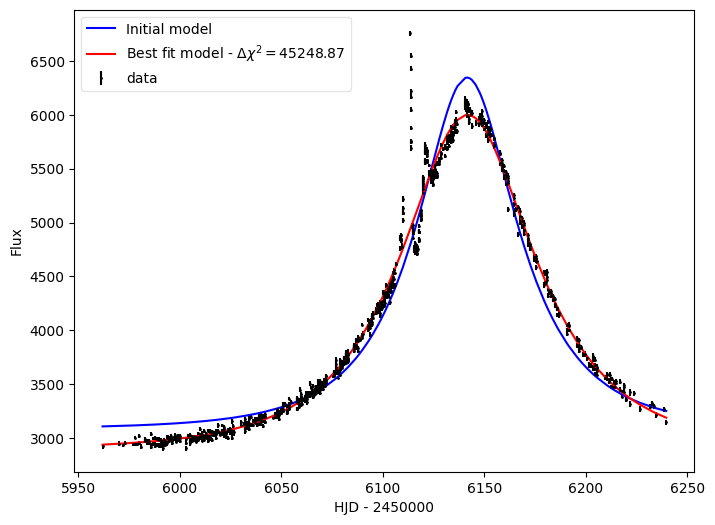

In [18]:

rhoi = 0.001
x0 = np.array([t0i, tEi, u0i, rhoi])
p = ['t0', 'tE', 'u0', 'rho']
init_modelmag = get_mag(x0, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p)
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['rho']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
final_model = source_flux * fin_modelmag + blend_flux

#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()
    

    

Fit a binary lens model from a random guess for binary parameters

1) Using Downhill Simplex

Final parameters:  {'t0': 6141.650214060421, 'tE': 54.35562886553174, 'u0': 0.6880895477354665, 'rho': 0.0006121440385624781, 'logs': -0.16323083406731098, 'logq': -5.1241267206606125, 'alpha': 284.83419074303697, 's': 0.6867033498098312, 'q': 7.514036136467587e-06}
Reduced chi2:  48.733497136836256
Delta chi2:  45203.621788583936


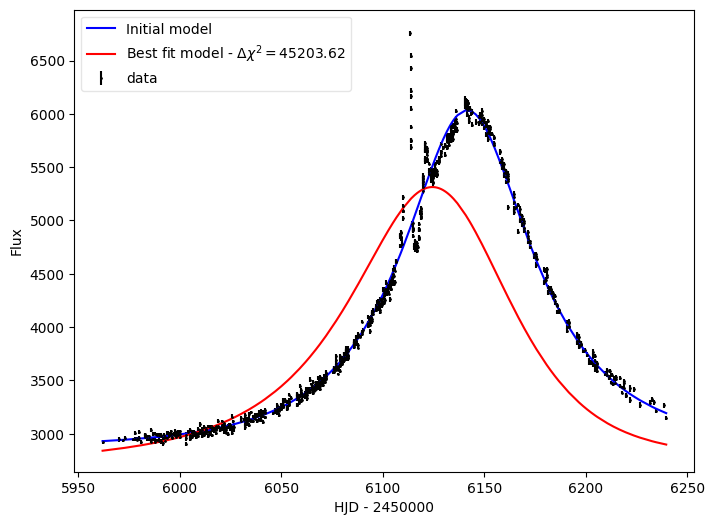

In [50]:
rhoi = 0.001
logsi = np.random.uniform(-2, 1)
logqi = np.random.uniform(-5, 0)
alphai = np.random.uniform(0.0, 360.0)

x0 = np.array([t0i, tEi, u0i, rhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'rho', 'logs', 'logq', 'alpha']
init_modelmag = get_mag(x0, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p)
fin_params['s'] = 10**(fin_params['logs'])
fin_params['q'] = 10**(fin_params['logq'])
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['rho'], fin_params['s'], fin_params['q'], fin_params['alpha']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
final_model = source_flux * fin_modelmag + blend_flux

#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()

2) Using MCMC 

Running MCMC with binary lens model...
Initial parameters: {'t0': 6141.413000000175, 'tE': 64.649, 'u0': 0.525, 'rho': 0.001, 'logs': -0.8763796434579125, 'logq': -0.24642846795041917, 'alpha': 263.51781905210584}
Using parameter-specific step sizes:
  t0: 1.00e-01
  tE: 1.00e-01
  u0: 1.00e-01
  rho: 1.00e-04
  logs: 1.00e-01
  logq: 5.00e-01
  alpha: 1.00e+00
\nMean acceptance fraction: 0.083
Cannot reliably calculate autocorrelation time: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [311.05347265 303.36733019 318.97199028 315.84591898 285.26890458
 200.70215083 218.68728953]
Using alternative convergence diagnostics...
Using burn-in period: 900 steps (30.0% of chain)
\nGelman-Rubin R-hat statistics (should be < 1.1 for convergence):
t0: 2.5728 (✗ Bad)
tE: 3.5936 (✗ Bad)
u0: 3.7787 (✗ Bad)
rho: 2.7495 (✗ Bad)
logs: 2.0948 (✗ Bad)
logq: 2.8597 (✗ Bad)
alpha: 4.6670 (✗ B

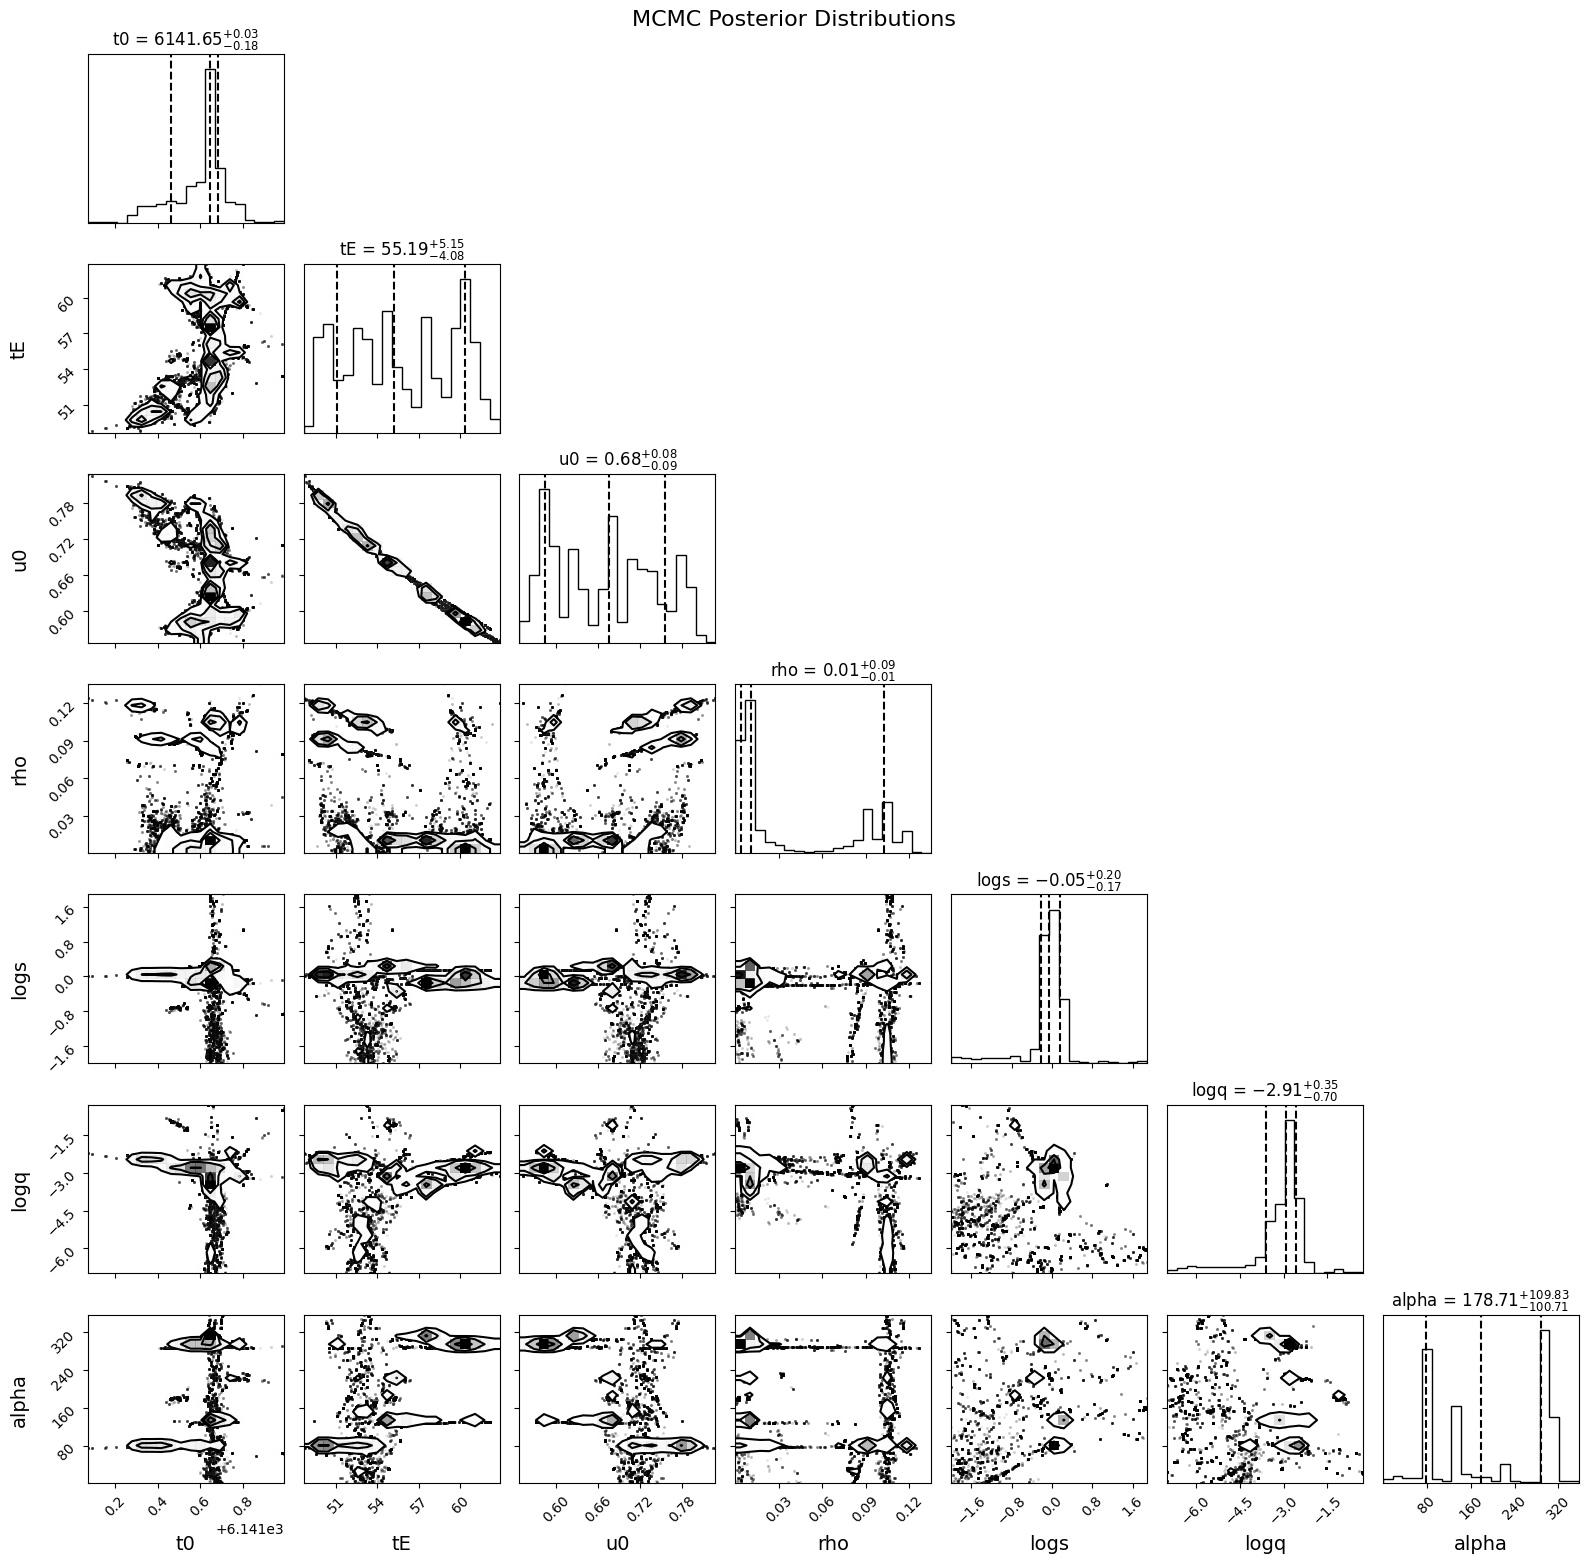

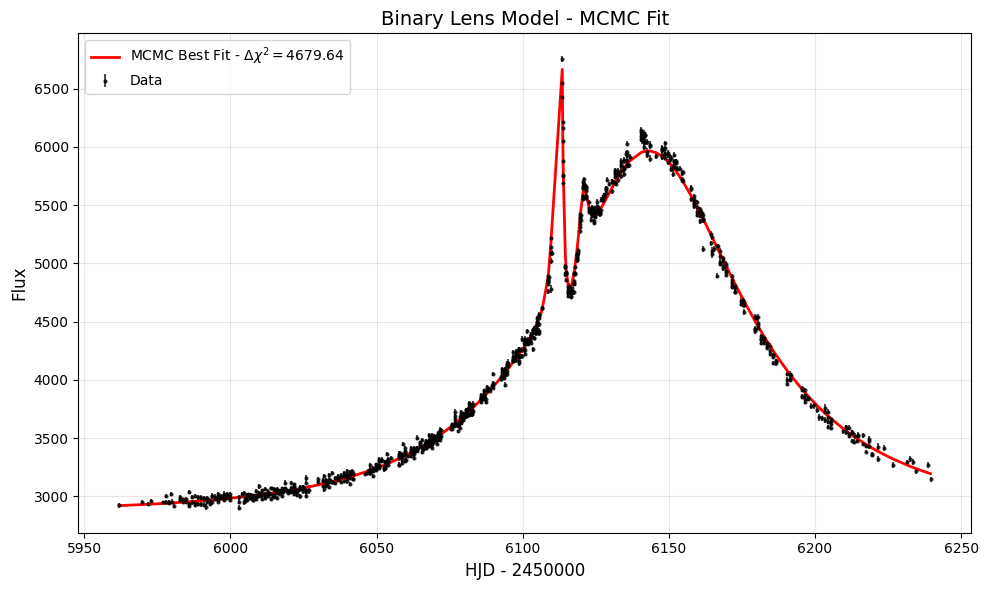

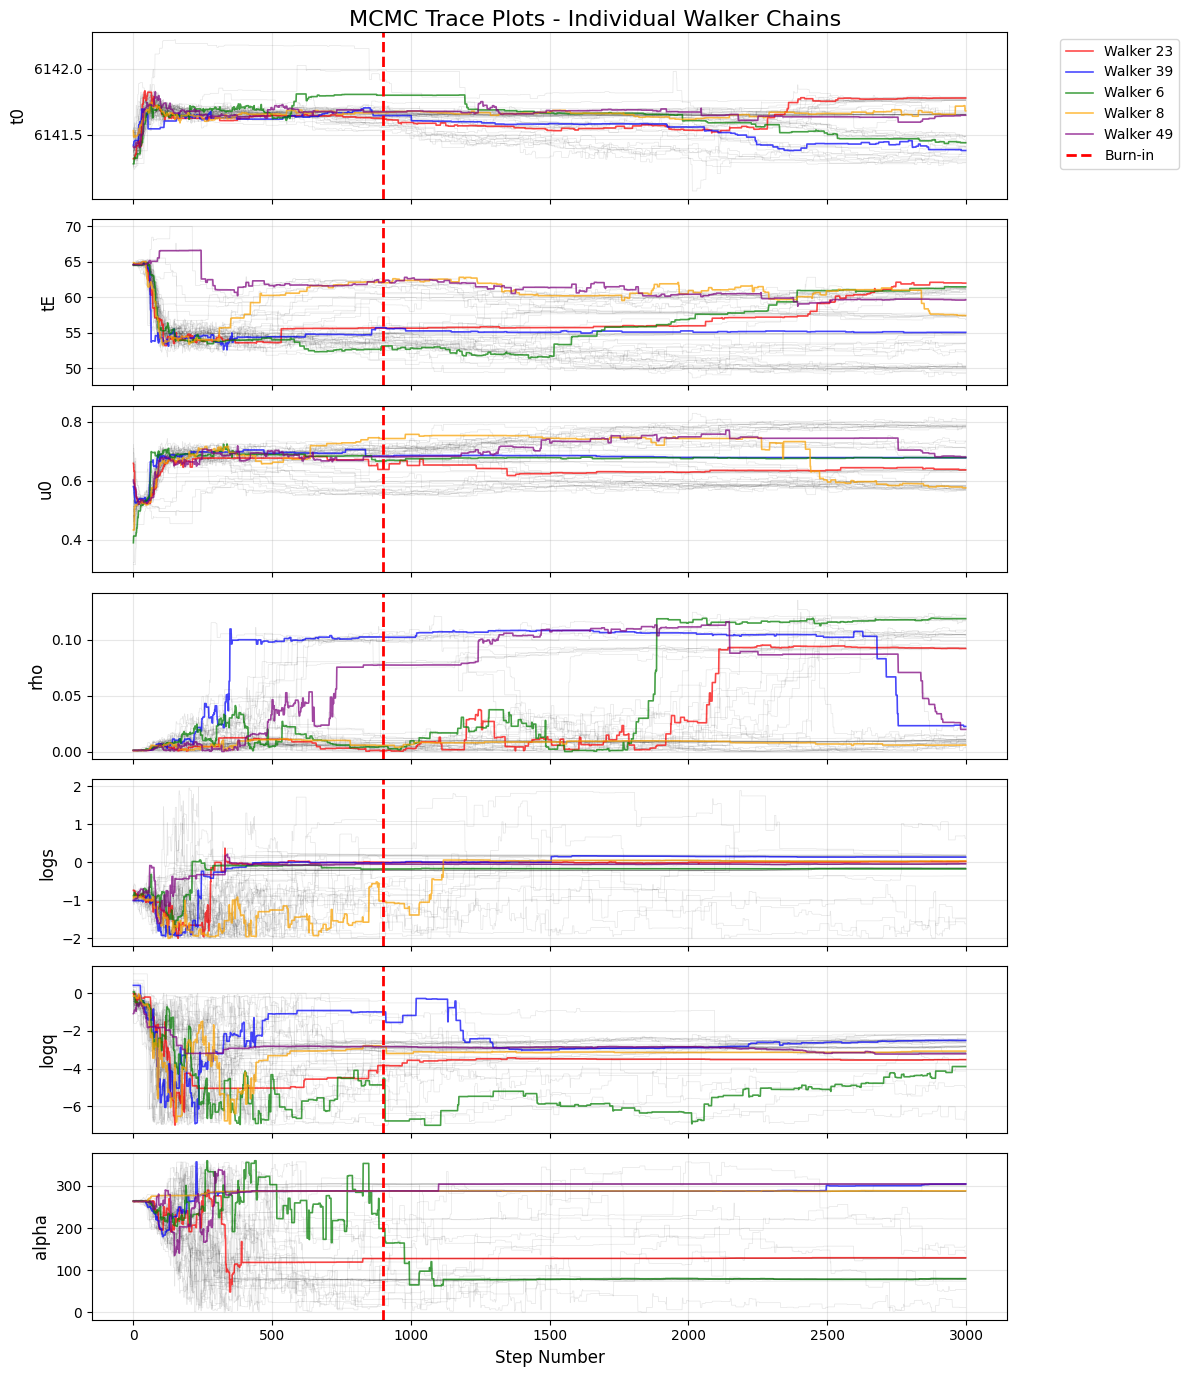

In [52]:
# Set random seed for reproducibility 
np.random.seed(42)

# Set up initial parameters for binary lens model
rhoi = 0.001
logsi = np.random.uniform(-2, 1)
logqi = np.random.uniform(-5, 0)
alphai = np.random.uniform(0.0, 360.0)

x0 = np.array([t0i, tEi, u0i, rhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'rho', 'logs', 'logq', 'alpha']

# Run MCMC analysis with all plots enabled
results = perform_mcmc_analysis(df, x0, p, steps=3000, walkers=50, param_scales=np.array([1e-1, 1e-1, 1e-1, 1e-4, 1e-1, 5e-1, 1.0]),
                               verbose=True, plot_corner=True, plot_fit=True, 
                               plot_traces=True, plot_convergence=False)


Fit a binary lens model from an informed guess

1. Using downhill simplex

Final parameters:  {'t0': 6141.830851678626, 'tE': 71.9296841571558, 'u0': 0.45939138749384184, 'logrho': -1.5082461559849527, 'logs': 0.12915202265644926, 'logq': -3.381687285159853, 'alpha': 227.47385332808386, 's': 1.3463315483464005, 'q': 0.0004152529389399032, 'rho': 0.031028004375475402}
Reduced chi2:  18.8414005517178
Delta chi2:  16895.806322476757


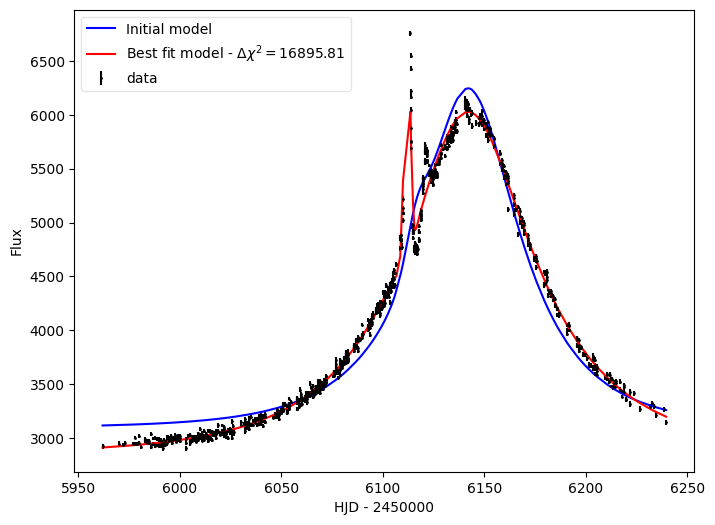

In [21]:
t0i = 6141.380
u0i = 0.545
tEi = 48.600
logrhoi = -1.344
logsi = 0.257
logqi = -2.211
alphai = 180 + np.degrees(0.829)

x0 = np.array([t0i, tEi, u0i, logrhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']
init_modelmag = get_mag(x0, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p)
fin_params['s'] = 10**(fin_params['logs'])
fin_params['q'] = 10**(fin_params['logq'])
fin_params['rho'] = 10**(fin_params['logrho'])
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['logrho'], fin_params['logs'], fin_params['logq'], fin_params['alpha']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
final_model = source_flux * fin_modelmag + blend_flux

#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()

2. Using MCMC

\nMaximum Likelihood Estimate (MLE) parameters:
t0: 6141.161494
tE: 63.012382
u0: 0.552496
logrho: -3.880679
logs: 0.159649
logq: -2.887470
alpha: 231.312833
\nMedian values with 1σ uncertainties:
t0: 6141.165772 +0.067661 -0.028534
tE: 62.281303 +0.724959 -10.738125
u0: 0.561853 +0.180325 -0.009436
logrho: -2.777289 +0.753668 -1.370236
logs: 0.161679 +0.032131 -0.002170
logq: -2.887131 +0.007833 -0.042446
alpha: 231.394771 +1.129177 -0.132572
\nMLE Chi-squared: 13005.81
MLE Reduced chi-squared: 13.73
MLE Delta chi-squared: 12058.81
\n============================================================
CONVERGENCE SUMMARY
⚠ POTENTIAL CONVERGENCE ISSUES:
  • 7 parameters have R-hat > 1.1
  • Low effective sample sizes
\n📊 SUMMARY:
  • Total steps: 5000
  • Burn-in: 1500 steps
  • Effective samples: 175000
  • Acceptance rate: 0.233
  • Min effective size: 41
  • Max R-hat: 43.203
\n============================================================


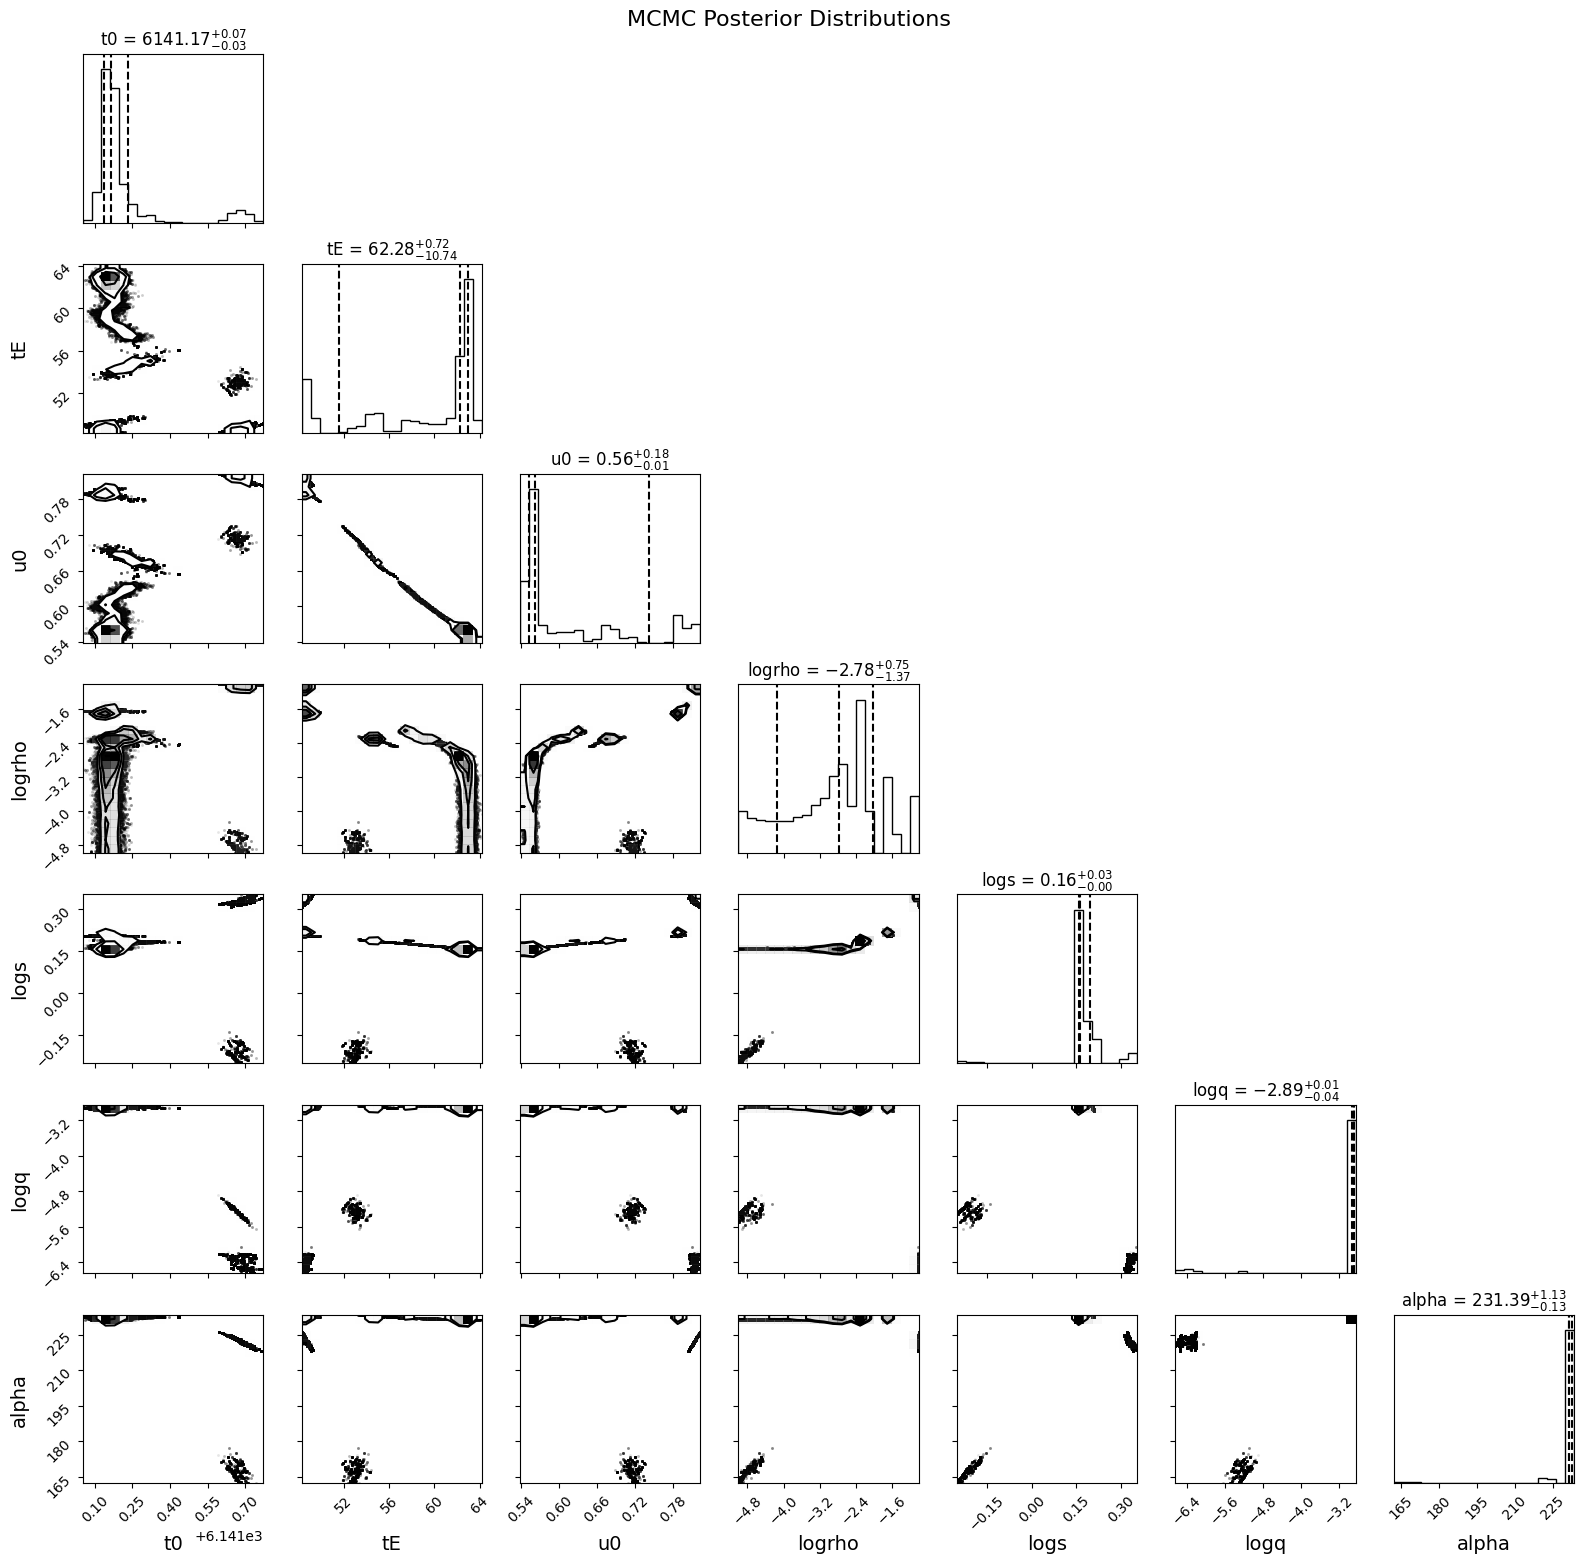

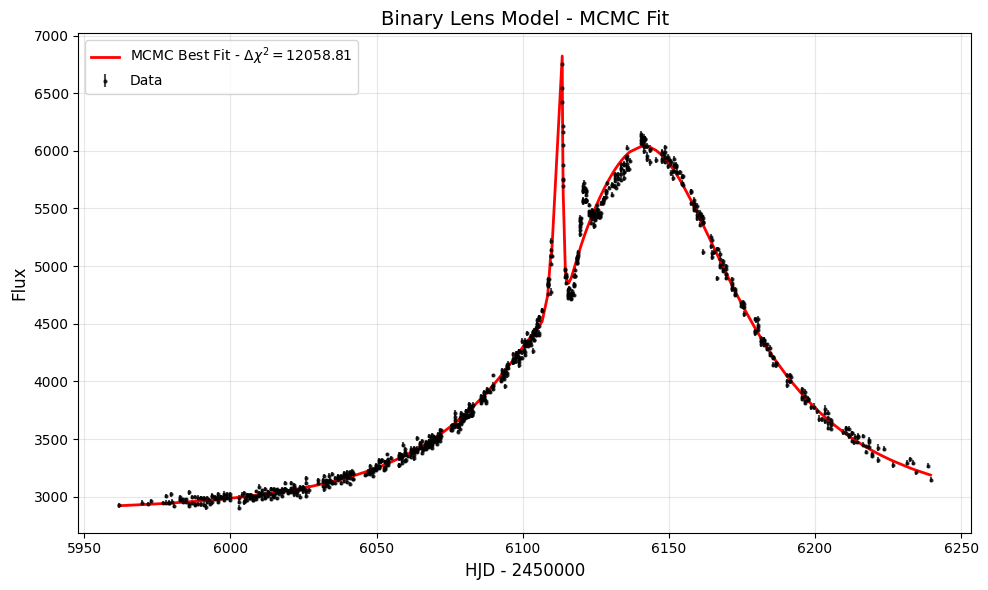

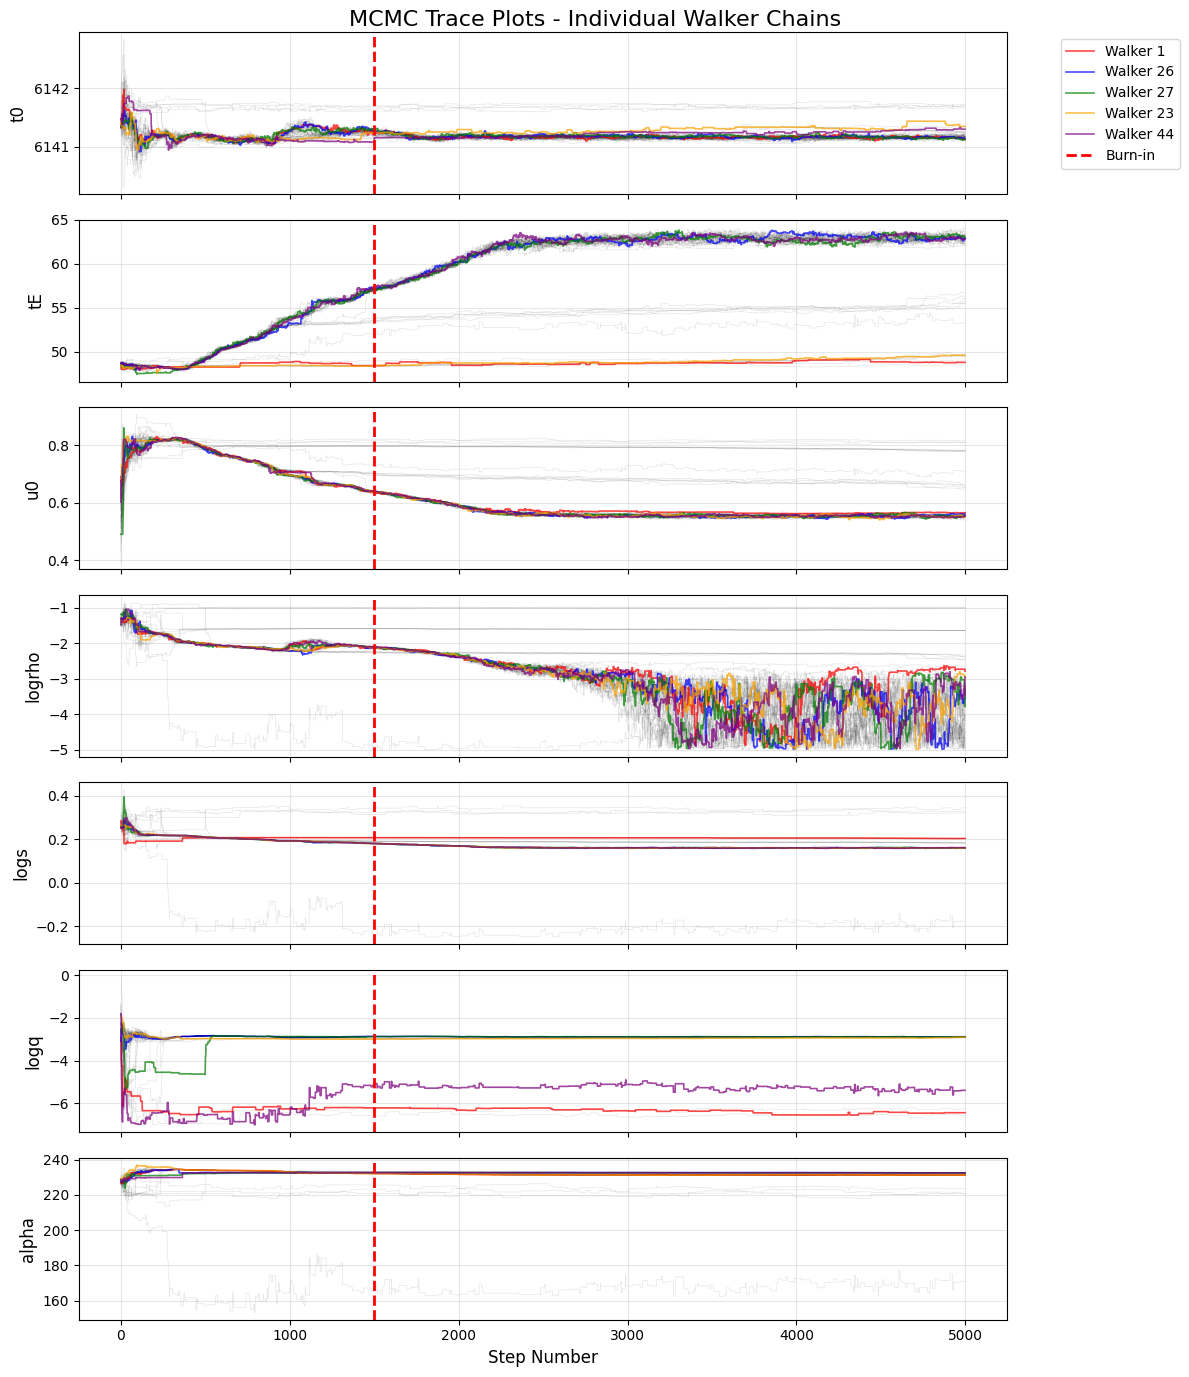

In [23]:
# Set random seed for reproducibility 
np.random.seed(46)

# Set up initial parameters for binary lens model
t0i = 6141.380
u0i = 0.545
tEi = 48.600
logrhoi = -1.344
logsi = 0.257
logqi = -2.211
alphai = 180 + np.degrees(0.829)

x0 = np.array([t0i, tEi, u0i, logrhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']

# Run MCMC analysis with all plots enabled
results = perform_mcmc_analysis(df, x0, p, steps=5000, walkers=50, param_scales=np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-2, 5e-1, 1.0]),
                               verbose=False, plot_corner=True, plot_fit=True, 
                               plot_traces=True, plot_convergence=False)

Grid Search 

1. Grid search without magnification maps

Write code to calculate maginification maps for any s, q, $\rho$

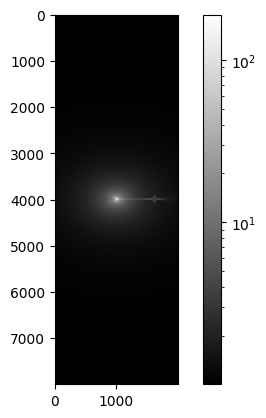

In [48]:
#plot the magnification map in greyscale in log scale
#read the fits file
mag_map = fits.getdata('magmap_test.fits')
fig, ax = plt.subplots()
plt.imshow(mag_map[:, 3000:5000], cmap='gray', norm='log')
plt.colorbar()
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ratio = 3./1.
ax.set_aspect(abs((x_right - x_left) / (y_high - y_low))*ratio)
plt.show()